In [1]:
import sys
sys.path.append('/home/ZhiLi/CRESTHH')
from cresthh.anuga import SWW_plotter
import numpy as np
import pandas as pd
%matplotlib inline
import geopandas as gpd
from cresthh.utils import flowAreaCalc as flow_area
from cresthh.utils import processSWW
from cresthh import metrics as met
from cresthh import anuga
from netCDF4 import Dataset
from glob import glob
from osgeo import gdal
from pyproj import Proj, CRS, transform

# Allow inline jshtml animations
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
rc('animation', html='jshtml')

In [2]:
sys.path.append('/home/ZhiLi/PlotGallory')
from matplotlibconfig import basic
basic()

In [3]:
def locale(x,y,splotter, loc='centroid'):
    if loc== 'centroid':
        xc= splotter.xc + splotter.xllcorner
        yc= splotter.yc + splotter.yllcorner
    elif loc=='vertice':
        xc= splotter.x + splotter.xllcorner
        yc= splotter.y + splotter.yllcorner
    else:
        raise ValueError
    iloc= np.argmin((xc-x)**2+(yc-y)**2)
    
    return iloc

# 1D streamflow

In [5]:
OUTLET=(284216.6385,3302831.7578)
crosssection= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/08076700.shp')

In [6]:
coupledSplotter= SWW_plotter('Coupled_10m_modified_mesh.sww')

Figure files for each frame will be stored in _plot


In [7]:
benchmark= processSWW('Coupled_10m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# coupled_30m= processSWW('Coupled_30m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
noncoupled_10m= processSWW('nonCoupled_10m_modified_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# coupled_noConstraint=processSWW('Coupled_10m_no_constraint_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# coupled_FAM= processSWW('Coupled_10m_flow_acc_mesh.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
infil=processSWW('Coupled_10m_modified_mesh_infiltration.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
# soil= processSWW('Coupled_10m_modified_mesh_Ksat.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))
saturated= processSWW('Coupled_10m_modified_mesh_saturated.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot


In [8]:
benchmark['area']= benchmark.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
noncoupled_10m['area']= noncoupled_10m.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
# coupled_30m['area']= coupled_30m.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
# coupled_FAM['area']= coupled_FAM.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
# coupled_noConstraint['area']= coupled_noConstraint.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
infil['area']= infil.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
# soil['area']= soil.apply(lambda x: flow_area(crosssection, x.stage), axis=1)
saturated['area']= saturated.apply(lambda x: flow_area(crosssection, x.stage), axis=1)

In [9]:
benchmark['Q']= benchmark.speed * benchmark.area
noncoupled_10m['Q']= noncoupled_10m.speed * noncoupled_10m.area
# coupled_30m['Q']= coupled_30m.speed * coupled_30m.area
# coupled_FAM['Q']= coupled_FAM.speed * coupled_FAM.area
# coupled_noConstraint['Q']= coupled_noConstraint.speed * coupled_noConstraint.area
infil['Q']= infil.speed * infil.area
# soil['Q']= soil.speed * soil.area
saturated['Q']= saturated.speed * saturated.area

In [11]:
from netCDF4 import Dataset
import matplotlib.tri as mtri
def interpolateSWW(swwfile, field, xi, yi, reduction=None):
    nc= Dataset(swwfile)
    if isinstance(field, str):
        if field=='depth':
            fea= nc['stage'][:].max(axis=0)- nc['elevation'][:]
        else:
            fea= nc[field][:][reduction]
    else:
        msg= 'not supported field'
        raise msg
        
#     interp_lin = mtri.CubicTriInterpolator(triang, z, kind='geom')
    triangles= nc['volumes'][:]
    x= nc['x'][:]
    y=nc['y'][:]
    triang= mtri.Triangulation(x, y, triangles)
    interp_lin = mtri.CubicTriInterpolator(triang, fea, kind='geom')
    xi,yi= np.meshgrid(xi,yi)
    zi_lin = interp_lin(xi, yi)
    
    return xi, yi, zi_lin

def interpolateSplotter(splotter,field, xi, yi):

    if isinstance(field, str):
        if field=='depth':
            fea= nc['stage'][:].max(axis=0)- nc['elevation'][:]
    elif isinstance(field, np.ndarray):
        fea= field
        
#     interp_lin = mtri.CubicTriInterpolator(triang, z, kind='geom')
    triangles= splotter.volumes
    x= splotter.x
    y= splotter.y
    triang= mtri.Triangulation(x, y, triangles)
    interp_lin = mtri.CubicTriInterpolator(triang, fea, kind='geom')
    xi,yi= np.meshgrid(xi,yi)
    zi_lin = interp_lin(xi, yi)
    
    return xi, yi, zi_lin
 

In [15]:
boundary= gpd.read_file('/home/ZhiLi/mesher/examples/08076700_new/stream_dem/DEM_10m/line_DEM_10m.shp')
x= np.array(boundary.geometry[0].coords)[:,0]-coupledSplotter.xllcorner
y=np.array(boundary.geometry[0].coords)[:,1]-coupledSplotter.yllcorner

# Level 1: Model engine

In [7]:
crest_Q_csv= pd.read_csv('ts.08076700.crest.csv').set_index('Time')

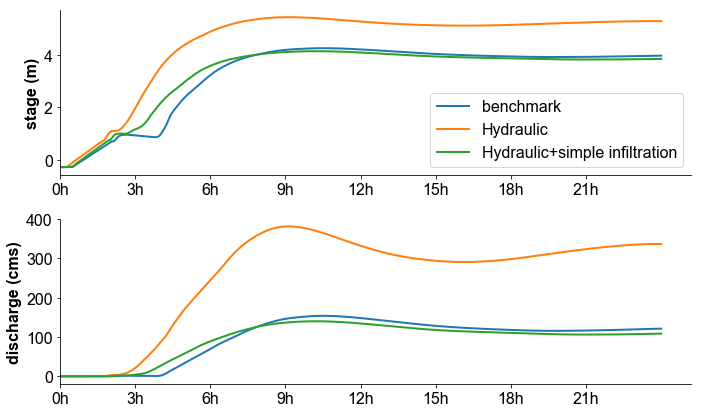

In [146]:
fig= plt.figure(figsize=(10,6))
ax= fig.add_subplot(211)
ax.plot(benchmark.stage.values, label='benchmark')
ax.plot(noncoupled_10m.stage.values, label='Hydraulic')
ax.plot(infil.stage.values, label='Hydraulic+simple infiltration')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('stage (m)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
plt.legend(fontsize=16);
ax= fig.add_subplot(212)
ax.plot(benchmark.Q.values, label='benchmark')
ax.plot(noncoupled_10m.Q.values, label='Hydraulic')
ax.plot(infil.Q.values, label='Hydraulic+simple infiltration')
# ax.plot(crest_Q_csv.iloc[:,0].values*0.2, label='CREST')
# iloc= locale(284222.90452033,3302822.64983592,coupledSplotter,'vertice')
# ax.plot(Q_grid[:,iloc])
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('discharge (cms)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
# plt.xticks(np.arange(0,24,3), ['%dh'%i for i in np.arange(0,24,3)])


In [357]:
xi,yi,MD_benchmark= interpolate('Coupled_10m_modified_mesh.sww', np.arange(0,38000,10), np.arange(0,25000,10))
xi,yi,MD_estimator= interpolate('Coupled_10m_modified_mesh_infiltration.sww', np.arange(0,38000,10), np.arange(0,25000,10))

In [358]:
MD_benchmark=MD_benchmark.filled(np.nan)
MD_estimator=MD_estimator.filled(np.nan)

In [359]:
# MD_benchmark= MD_benchmark.filled(np.nan)
# MD_estimator= MD_benchmark.filled(np.nan)
new_field= np.zeros(MD_benchmark.shape)
rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator>0.2) & (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=3
rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator<=0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=2
rows,cols= np.where((MD_benchmark<=0.2) & (MD_estimator>0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=1

new_field[np.isnan(MD_benchmark)]=np.nan

# new_field[mask_misses]=2
# new_field[mask_false]=1

hits_p= float((new_field==3).sum())/((~np.isnan(new_field)).sum())*100.
misses_p= float((new_field==2).sum())/((~np.isnan(new_field)).sum())*100.
false_p= float((new_field==1).sum())/((~np.isnan(new_field)).sum())*100.
neg_p = float((new_field==0).sum())/((~np.isnan(new_field)).sum())*100.

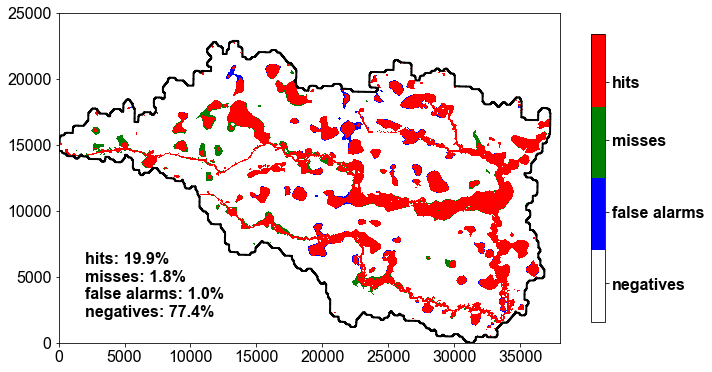

In [360]:
cmap = ListedColormap(['white', 'b', 'g', 'r'])
fig=plt.figure(figsize=(10,6))
# estimator.triang.set_mask(estimator.depth.max(axis=0) <=0.2)
plt.imshow(new_field, origin='lower left', cmap=cmap, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
cbar= plt.colorbar(ticks=[0.4,1.15,1.9,2.5], shrink=0.7)
# cbar.ax.set_yticks([1.25,2.00,2.75])
cbar.ax.set_yticklabels(['negatives','false alarms','misses','hits'], weight='bold')
plt.text(2000,2000,'hits: %.1f%s\nmisses: %.1f%s\nfalse alarms: %.1f%s\nnegatives: %.1f%s'%(hits_p,'%', misses_p,'%', false_p,'%', 100-hits_p-misses_p-false_p,'%'), fontsize=16, weight='bold')
plt.plot(x, y, 'k');

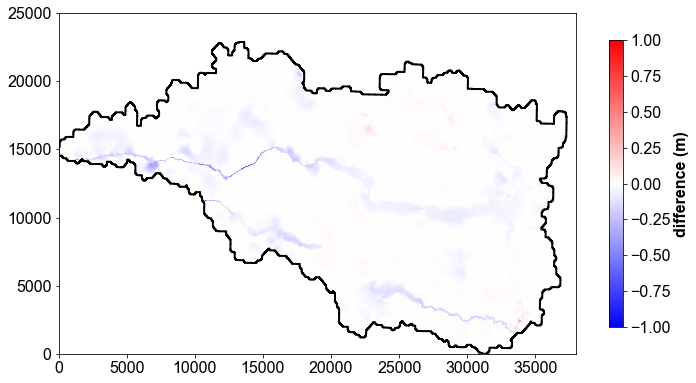

In [361]:
difference= MD_estimator- MD_benchmark
fig=plt.figure(figsize=(10,6))
plt.imshow(difference, origin='lower left', cmap='bwr', vmin=-1, vmax=1, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
cbar= plt.colorbar(shrink=0.7)
cbar.ax.set_ylabel('difference (m)')
plt.plot(x, y, 'k');

In [13]:
def visualize_binary(xi, yi, MD_estimator, MD_benchmark):
    global x, y
    MD_benchmark=MD_benchmark.filled(np.nan)
    MD_estimator=MD_estimator.filled(np.nan)
    new_field= np.zeros(MD_benchmark.shape)
    rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator>0.2) & (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
    new_field[rows, cols]=3
    rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator<=0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
    new_field[rows, cols]=2
    rows,cols= np.where((MD_benchmark<=0.2) & (MD_estimator>0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
    new_field[rows, cols]=1

    new_field[np.isnan(MD_benchmark)]=np.nan

    # new_field[mask_misses]=2
    # new_field[mask_false]=1

    hits_p= float((new_field==3).sum())/((~np.isnan(new_field)).sum())*100.
    misses_p= float((new_field==2).sum())/((~np.isnan(new_field)).sum())*100.
    false_p= float((new_field==1).sum())/((~np.isnan(new_field)).sum())*100.
    neg_p = float((new_field==0).sum())/((~np.isnan(new_field)).sum())*100.
    cmap = ListedColormap(['white', 'b', 'g', 'r'])
#     fig=plt.figure(figsize=(10,6))
    # estimator.triang.set_mask(estimator.depth.max(axis=0) <=0.2)
    map= plt.imshow(new_field, origin='lower left', cmap=cmap, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
#     cbar= plt.colorbar(ticks=[0.4,1.15,1.9,2.5], shrink=0.7)
#     # cbar.ax.set_yticks([1.25,2.00,2.75])
#     cbar.ax.set_yticklabels(['negatives','false alarms','misses','hits'], weight='bold')
    plt.text(0,0,'TP: %.1f%s\nFN: %.1f%s\nFP: %.1f%s\nTN: %.1f%s'%(hits_p,'%', misses_p,'%', false_p,'%', 100-hits_p-misses_p-false_p,'%'), fontsize=16, weight='bold')
    plt.plot(x, y, 'k');
    plt.axis('off')
    return map
    
def visualize_depth(xi, yi, MD_estimator, MD_benchmark):
    global x, y
    MD_benchmark=MD_benchmark.filled(np.nan)
    MD_estimator=MD_estimator.filled(np.nan)    
    difference= MD_estimator- MD_benchmark
    map= plt.imshow(difference, origin='lower left', cmap='bwr', vmin=-1, vmax=1, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
    plt.plot(x, y, 'k');
    plt.axis('off')
    
    return map

In [12]:
xi,yi,MD_benchmark= interpolateSWW('Coupled_10m_modified_mesh.sww', 'depth',np.arange(0,38000,10), np.arange(0,25000,10))
xi,yi,MD_noncouple= interpolateSWW('nonCoupled_10m_modified_mesh.sww', 'depth', np.arange(0,38000,10), np.arange(0,25000,10))  
xi,yi,MD_infiltration= interpolateSWW('Coupled_10m_modified_mesh_infiltration.sww', 'depth', np.arange(0,38000,10), np.arange(0,25000,10))  

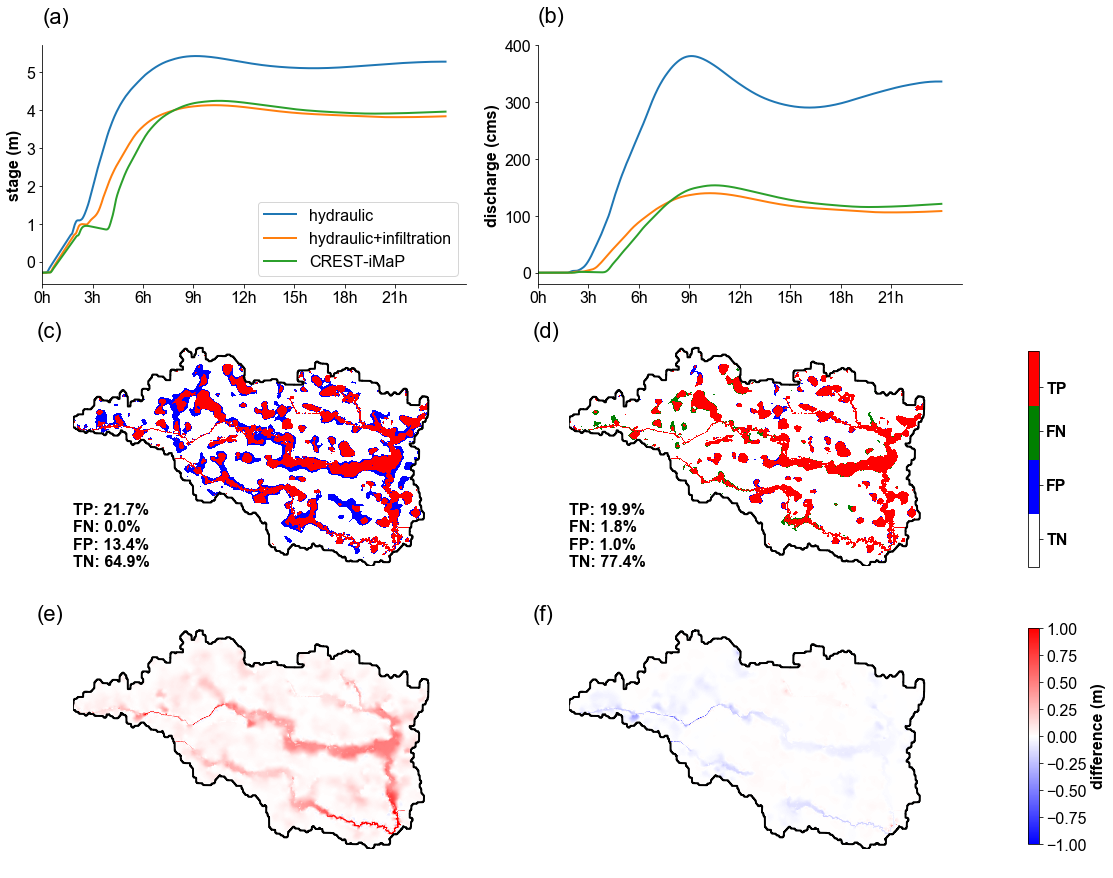

In [16]:
from matplotlib import gridspec

fig = plt.figure(figsize=(16,12),constrained_layout=True)
gs = gridspec.GridSpec(3, 7, figure=fig)
ax= fig.add_subplot(gs[0,:3])
ax.plot(noncoupled_10m.stage.values, label='hydraulic')
ax.plot(infil.stage.values, label='hydraulic+infiltration')
ax.plot(benchmark.stage.values, label='CREST-iMaP')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('stage (m)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
plt.legend(fontsize=16);
# plt.title('(a)', pad=20, loc='left')
plt.text(0, 6.3, '(a)', fontsize=22)
ax= fig.add_subplot(gs[0,3:6])

ax.plot(noncoupled_10m.Q.values, label='Hydraulic')
ax.plot(infil.Q.values, label='Hydraulic+infiltration')
ax.plot(benchmark.Q.values, label='CREST-iMaP')
# ax.plot(crest_Q_csv.iloc[:,0].values*0.2, label='CREST')
# iloc= locale(284222.90452033,3302822.64983592,coupledSplotter,'vertice')
# ax.plot(Q_grid[:,iloc])
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('discharge (cms)')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
# plt.title('(b)', pad=20, loc='left')
plt.text(0, 440, '(b)', fontsize=22)


ax= fig.add_subplot(gs[1,:3])
visualize_binary(xi, yi, MD_noncouple, MD_benchmark)
# plt.title('(c)', pad=20, loc='left')
plt.text(-3800, 24000, '(c)', fontsize=22)
ax= fig.add_subplot(gs[1,3:6])
map= visualize_binary(xi, yi, MD_infiltration, MD_benchmark)
# plt.title('(d)', pad=20, loc='left')
plt.text(-3800, 24000, '(d)', fontsize=22)
# ax= fig.add_subplot(gs[0,6])
cbar= plt.colorbar(mappable=map, cax=fig.add_axes([0.9, 0.37,0.01,0.25]),ticks=[0.4,1.15,1.9,2.5], shrink=0.2)
cbar.ax.set_yticklabels(['TN','FP','FN','TP'], weight='bold')


ax= fig.add_subplot(gs[2,:3])
visualize_depth(xi, yi, MD_noncouple, MD_benchmark)
plt.text(-3800, 24000, '(e)', fontsize=22)
ax= fig.add_subplot(gs[2,3:6])
map= visualize_depth(xi, yi, MD_infiltration, MD_benchmark)
# plt.title('(f)', pad=20, loc='left')
plt.text(-3800, 24000, '(f)', fontsize=22)
# ax= fig.add_subplot(gs[1,6])
cbar= plt.colorbar(mappable=map, cax=fig.add_axes([0.9, 0.05,0.01,0.25]), shrink=0.2)
cbar.ax.set_ylabel('difference (m)')
# plt.text(-1000, 30000, '(f)')
plt.tight_layout();


In [17]:
extent = fig.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
fig.savefig('src/composite_123D_difference.png', dpi=500, bbox_inches=extent.expanded(1.1, 1.2))

## Soil moisture and infiltration

In [34]:
coupledSplotter= SWW_plotter('Coupled_10m_modified_mesh.sww', start_time=pd.to_datetime('20170825000000'))
infiltrationSplotter= SWW_plotter('Coupled_10m_modified_mesh_infiltration.sww', start_time=pd.to_datetime('20170825000000'))
noncoupledSplotter=SWW_plotter('nonCoupled_10m_modified_mesh.sww', start_time=pd.to_datetime('20170825000000'))
new= SWW_plotter('Coupled_10m_new.sww', start_time=pd.to_datetime('20170825000000'))
soilSplotter= SWW_plotter('Coupled_10m_modified_mesh_Ksat.sww', start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot
Figure files for each frame will be stored in _plot


In [35]:
from glob import glob
from osgeo import gdal
soil_pth= '/hydros/ZhiLi/excessive_rain/output/simu/excess_rain/sm*.tif'
exc_rain_pth= '/hydros/ZhiLi/excessive_rain/output/simu/excess_rain/surR*.tif'
soil_files= glob(soil_pth)
exc_rain_files= glob(exc_rain_pth)

In [36]:
crest_SM= []
for soil_file in sorted(soil_files):
    raster= gdal.Open(soil_file)
    crest_SM.append(raster.ReadAsArray())
crest_SM= np.stack(crest_SM)
crest_SM[crest_SM==-9]= np.nan

In [37]:
infiltration_rate= np.zeros(coupledSplotter.exc_rain.shape[0])
infiltration_rate[2:62]= 100-coupledSplotter.exc_rain[2:62,:].mean(axis=1) * 3600 *1000
infiltration_rate_infiltration= np.zeros(infiltrationSplotter.exc_rain.shape[0])
infiltration_rate_infiltration[2:62]= 100-infiltrationSplotter.exc_rain[2:62,:].mean(axis=1) * 3600 *1000
infiltration_rate_soil= np.zeros(soilSplotter.exc_rain.shape[0])
infiltration_rate_soil[2:62] = 100-soilSplotter.exc_rain[2:62,:].mean(axis=1) * 3600 *1000

In [38]:
infiltration_rate_crest= []
for exc_rain_file in sorted(exc_rain_files):
    raster= gdal.Open(exc_rain_file)
    arr= raster.ReadAsArray()
    arr[arr==-9]=np.nan
    infiltration_rate_crest.append(100-arr)
infiltration_rate_crest= np.stack(infiltration_rate_crest)

xi,yi,soil= interpolateSWW('Coupled_10m_modified_mesh.sww', 'excess_rain', np.arange(0,38000,10), np.arange(0,25000,10), 31)
soil= soil*1000.*3600.
arr2raster('excess_rain_coupled.tif', soil, xi, yi, coupledSplotter.xllcorner, coupledSplotter.yllcorner)

xi,yi,soil= interpolateSWW('nonCoupled_10m_modified_mesh.sww', 'excess_rain', np.arange(0,38000,10), np.arange(0,25000,10), 31)
soil= soil*1000.*3600.
arr2raster('excess_rain_noncoupled.tif', soil, xi, yi, coupledSplotter.xllcorner, coupledSplotter.yllcorner)

xi,yi,soil= interpolateSWW('Coupled_10m_modified_mesh_infiltration.sww', 'excess_rain', np.arange(0,38000,10), np.arange(0,25000,10), 31)
soil= soil*1000.*3600.
arr2raster('excess_rain_infiltration.tif', soil, xi, yi, coupledSplotter.xllcorner, coupledSplotter.yllcorner)

xi,yi,soil= interpolateSWW('Coupled_10m_modified_mesh_Ksat.sww', 'excess_rain', np.arange(0,38000,10), np.arange(0,25000,10), 31)
soil= soil*1000.*3600.
arr2raster('excess_rain_soil.tif', soil, xi, yi, coupledSplotter.xllcorner, coupledSplotter.yllcorner)

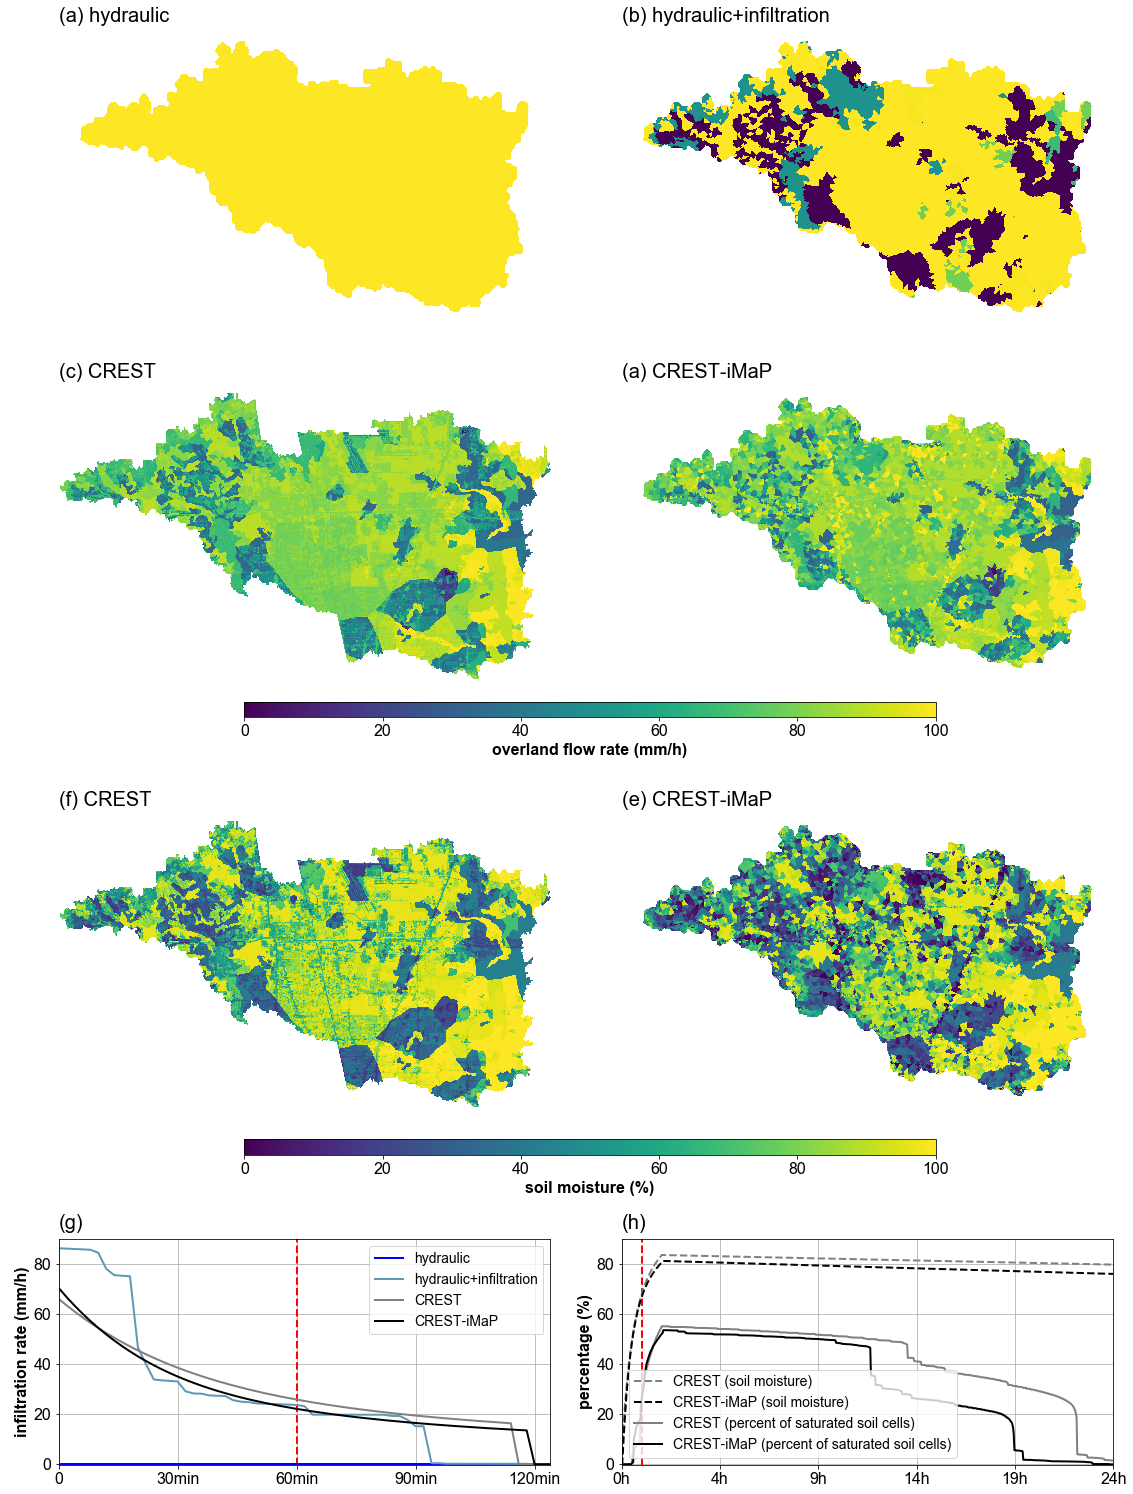

In [40]:
import matplotlib.gridspec as gridspec
# fig= plt.figure()
fig = plt.figure(figsize=(16,21),constrained_layout=True)
gs = gridspec.GridSpec(21, 6, figure=fig)
# ax= fig.add_subplot(421)
ax= fig.add_subplot(gs[0:5, 0:3])
plt.tripcolor(noncoupledSplotter.triang, facecolors=noncoupledSplotter.exc_rain[30]*1000.*3600., vmin=0, vmax=100)
plt.title('(a) hydraulic', loc='left')
# plt.colorbar(shrink=0.7)
plt.axis('off')
# ax= fig.add_subplot(422)
ax= fig.add_subplot(gs[0:5, 3:])
plt.tripcolor(noncoupledSplotter.triang, facecolors=infiltrationSplotter.exc_rain[30]*1000.*3600., vmin=0, vmax=100)
plt.title('(b) hydraulic+infiltration', loc='left')
plt.axis('off')
# plt.colorbar(shrink=0.7)
# ax= fig.add_subplot(423)
ax= fig.add_subplot(gs[5:10, 0:3])
map=plt.imshow(100.-infiltration_rate_crest[30], interpolation='nearest', aspect='auto', vmin=0, vmax=100)
plt.title('(c) CREST', loc='left')
plt.axis('off')
# plt.colorbar(shrink=0.7)
# ax= fig.add_subplot(424)
ax= fig.add_subplot(gs[5:10, 3:])

plt.tripcolor(coupledSplotter.triang, facecolors=coupledSplotter.exc_rain[30]*1000.*3600., vmin=0, vmax=100)
plt.title('(a) CREST-iMaP', loc='left')
plt.axis('off')
# plt.colorbar(shrink=0.7);

# ax= fig.add_subplot(gs[10, 2:4])

cbar=plt.colorbar(orientation='horizontal',cax=fig.add_axes([0.22,0.52,0.6,0.01]), mappable=map, shrink=0.7, pad=0, fraction=0.1)
cbar.ax.set_xlabel('overland flow rate (mm/h)')

# ax= fig.add_subplot(425)
ax= fig.add_subplot(gs[11:16, 0:3])
map= plt.imshow(crest_SM[30], interpolation='nearest', aspect='auto', vmin=0, vmax=100)
plt.title('(f) CREST', loc='left')
plt.axis('off')
# plt.colorbar(shrink=0.7);

# ax= fig.add_subplot(426)
ax= fig.add_subplot(gs[11:16, 3:])

plt.tripcolor(coupledSplotter.triang, facecolors=coupledSplotter.SM[30], vmin=0, vmax=100)
plt.title('(e) CREST-iMaP', loc='left')
plt.axis('off')
# plt.colorbar(shrink=0.7);

# ax= fig.add_subplot(gs[16, 1:5])
# cax= ax.add_axes([0.2,0.8,0,1])
cbar=plt.colorbar(orientation='horizontal',cax=fig.add_axes([0.22,4./21.+0.04,0.6,0.01]), mappable=map, shrink=0.2, pad=0)
cbar.ax.set_xlabel('soil moisture (%)')

# ax= fig.add_subplot(427)
ax= fig.add_subplot(gs[17:, 0:3])
ax.plot([0,62],[0,0], 'b',label='hydraulic')
ax.plot(infiltration_rate_infiltration[2:],'#6197B6',label='hydraulic+infiltration')
infiltration_rate_crest_mean= np.nanmean(np.nanmean(infiltration_rate_crest, axis=1), axis=1)
infiltration_rate_crest_mean[infiltration_rate_crest_mean==100.]=0
ax.plot(infiltration_rate_crest_mean[2:],'gray', label='CREST')
ax.plot(infiltration_rate[2:],'k', label='CREST-iMaP')
ax.vlines(30,-0.2,90,'r', linestyle='--')
ax.set_ylabel('infiltration rate (mm/h)')
ax.set_xlim([0,62])
ax.set_ylim([-0.2,90])
ax.set_xticks(np.linspace(0,60,5))
ax.set_xticklabels(['0', '30min','60min','90min','120min'])
ax.set_title('(g)', loc='left', pad=10)

plt.legend()
plt.grid()

# ax= fig.add_subplot(428)
ax= fig.add_subplot(gs[17:, 3:])
crest_mean_SM= np.nanmean(np.nanmean(crest_SM, axis=1), axis=1)

ax.plot(crest_mean_SM, 'gray', linestyle='--',label='CREST (soil moisture)')
ax.plot(new.SM.mean(axis=1),'k--',label='CREST-iMaP (soil moisture)')

num_saturated= crest_mean_SM>95.
num_saturated= []
for i in range(len(crest_SM)):
    _num_saturated= (crest_SM[i]>95.).sum()
    num_saturated.append(_num_saturated)
num_cells= (~np.isnan(crest_SM[0,:,:])).sum()
ax.plot(np.array(num_saturated)/float(num_cells)*100.,'gray', label='CREST (percent of saturated soil cells)')
num_saturated= new.SM>95.
ax.plot(num_saturated.sum(axis=1)/float(new.SM.shape[1])*100.,'k', label='CREST-iMaP (percent of saturated soil cells)')
ax.vlines(30,-0.2,90,'r', linestyle='--')
ax.set_ylabel('percentage (%)')
ax.set_xticks(np.linspace(0,30*24,6))
ax.set_ylim([-0.2,90])
ax.set_xticklabels(['%dh'%m for m in np.linspace(0,24,6)])
ax.set_xlim([0,30*24])
ax.set_title('(h)', loc='left', pad=10)
ax.legend()
plt.grid()
plt.tight_layout();

In [41]:
fig.savefig('src/composite_SM_infiltration.png', dpi=500)

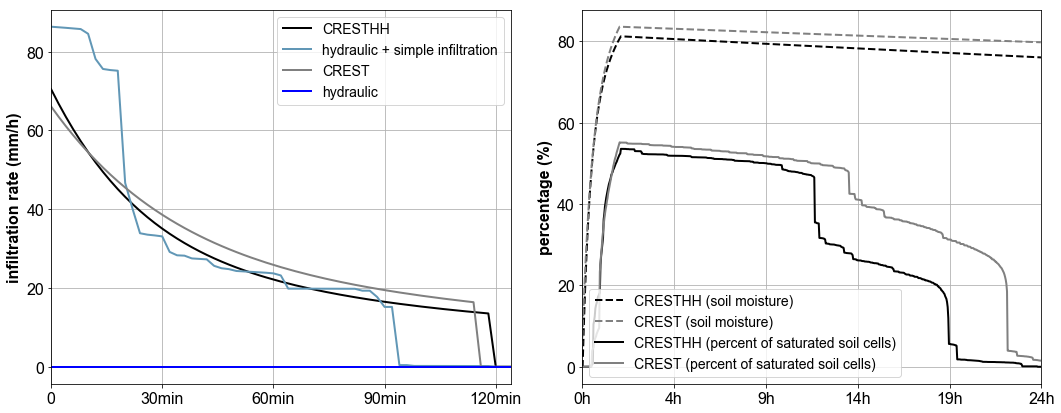

In [61]:
fig= plt.figure(figsize=(15,6))
ax=fig.add_subplot(121)
ax.plot(infiltration_rate[2:],'k', label='CRESTHH')
ax.plot(infiltration_rate_infiltration[2:],'#6197B6',label='hydraulic + simple infiltration')
infiltration_rate_crest_mean= np.nanmean(np.nanmean(infiltration_rate_crest, axis=1), axis=1)
infiltration_rate_crest_mean[infiltration_rate_crest_mean==100.]=0
ax.plot(infiltration_rate_crest_mean[2:],'gray', label='CREST')
ax.plot([0,62],[0,0], 'b',label='hydraulic')
ax.set_ylabel('infiltration rate (mm/h)')
ax.set_xlim([0,62])
ax.set_xticks(np.linspace(0,60,5))
ax.set_xticklabels(['0', '30min','60min','90min','120min'])
plt.legend()
plt.grid()
ax= fig.add_subplot(122)
# crest_mean_SM= np.nanmean(np.nanmean(crest_SM, axis=1), axis=1)
ax.plot(new.SM.mean(axis=1),'k--',label='CRESTHH (soil moisture)')
ax.plot(crest_mean_SM, 'gray', linestyle='--',label='CREST (soil moisture)')
# ax2 = ax.twinx()
num_saturated= new.SM>95.
ax.plot(num_saturated.sum(axis=1)/float(new.SM.shape[1])*100.,'k', label='CRESTHH (percent of saturated soil cells)')
num_saturated= crest_mean_SM>95.
num_saturated= []
for i in range(len(crest_SM)):
    _num_saturated= (crest_SM[i]>95.).sum()
    num_saturated.append(_num_saturated)
num_cells= (~np.isnan(crest_SM[0,:,:])).sum()
ax.plot(np.array(num_saturated)/float(num_cells)*100.,'gray', label='CREST (percent of saturated soil cells)')
# ax.plot()
# ax2.set_ylabel('percent of saturated soils (%)')
ax.set_ylabel('percentage (%)')
ax.set_xticks(np.linspace(0,30*24,6))
ax.set_xticklabels(['%dh'%m for m in np.linspace(0,24,6)])
ax.set_xlim([0,30*24])
ax.legend()
plt.grid();
# ax.set_xticks(np.linspace(0,60,5))
# ax.set_xticklabels(['0', '0.5h','1h','1.5h','2h']);

In [12]:
fig.savefig('src/infiltration_SM.png', dpi=500)

In [125]:
disc_pth= '/hydros/ZhiLi/excessive_rain/output/simu/excess_rain/q*.tif'
soil_files= glob(disc_pth)
crest_Q= []
for soil_file in sorted(soil_files):
    raster= gdal.Open(soil_file)
    crest_Q.append(raster.ReadAsArray())
crest_Q= np.stack(crest_Q)
crest_Q[crest_Q==-9]= np.nan

In [112]:
import geopandas as gpd
# pnt_1= (283408,3312171)
pnt_1= (283335.38,3312170.06)
# pnt_2= (283224.0657,3312235.3973)
pnt_2= (283239.037897,3312213.226924)
# pnt_3= (284210.7,3303059.5)
pnt_3= 
# pnt_4= (283875.9465,3303052.9056)
pnt_4= (283989.318267,3302945.231523)
cross_1= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/trib_1.shp')
cross_2= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/trib_2.shp')
cross_3= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/trib_3.shp')
cross_4= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/trib_4.shp')

In [9]:
cross= [cross_1, cross_2, cross_3, cross_4]

In [41]:
discharges= []
for i, point in enumerate([pnt_1, pnt_2, pnt_3, pnt_4]):
    xc= noncoupledSplotter.xc + noncoupledSplotter.xllcorner
    yc= noncoupledSplotter.yc + noncoupledSplotter.yllcorner
    iloc= np.argmin((xc-pnt_1[0])**2 + (yc-pnt_1[1])**2)
    _stages= noncoupledSplotter.stage[:,iloc]
    _speeds= noncoupledSplotter.speed[:,iloc]
    _areas= np.array([flow_area(cross[i], _stage) for _stage in _stages])
    _discharge= _areas * _speeds
    discharges.append(_discharge)

In [37]:
import copy
discharge_coupled= copy.deepcopy(discharges)
discharge_noncoupled= copy.deepcopy(discharges)

discharge_infiltration= copy.deepcopy(discharges)

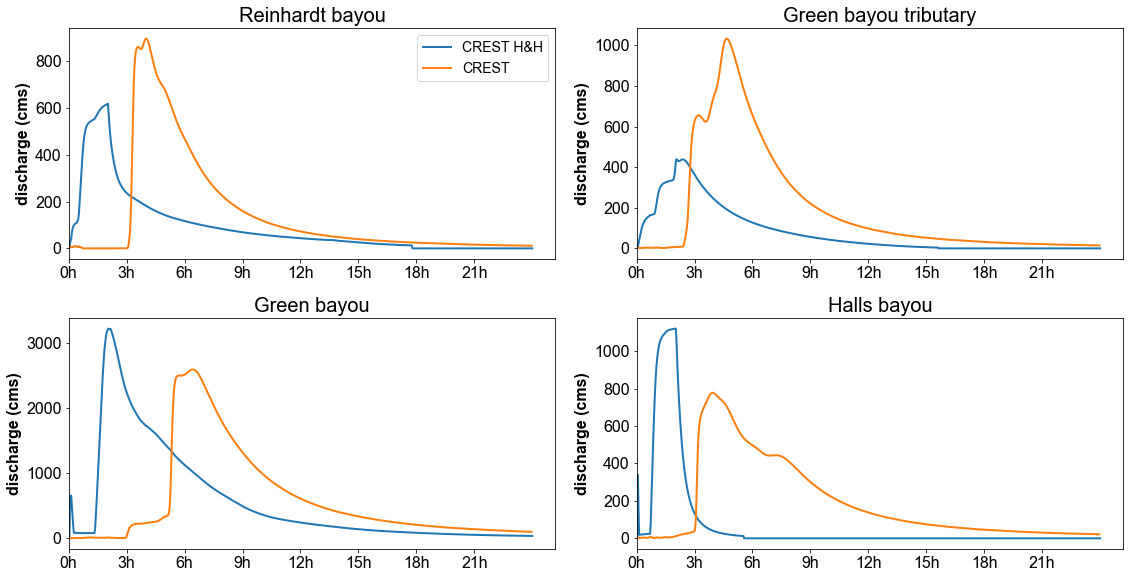

In [132]:
fig=plt.figure(figsize=(16,12))
ax= fig.add_subplot(321)
pnt_1= (284364.96999,3313530.71875)
iloc_1= locale(pnt_1[0],pnt_1[1], coupledSplotter,loc='vertice')
plt.plot(Q_grid[:,iloc_1], label='CREST H&H')
plt.plot(crest_Q[:,999,3761], label='CREST')
plt.title('Reinhardt bayou')
plt.legend()
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax= fig.add_subplot(322)
pnt_2= (267217.4644589,3316142.1493395)
iloc_2= locale(pnt_2[0],pnt_2[1], coupledSplotter,loc='vertice')
plt.plot(Q_grid[:,iloc_2])
plt.plot(crest_Q[:,1165,2975])
plt.title('Green bayou tributary')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax= fig.add_subplot(323)
pnt= (284212.566477,3303090.739507)
iloc= locale(pnt[0],pnt[1], coupledSplotter,loc='vertice')
plt.plot(Q_grid[:,iloc])
plt.plot(crest_Q[:,2018,3768])
plt.title('Green bayou')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax= fig.add_subplot(324)
pnt= (283989.674447,3302946.125827)
iloc= locale(pnt[0],pnt[1], coupledSplotter,loc='vertice')
plt.plot(Q_grid[:,iloc])
plt.plot(crest_Q[:,2021,3727])
plt.title('Halls bayou')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None]);


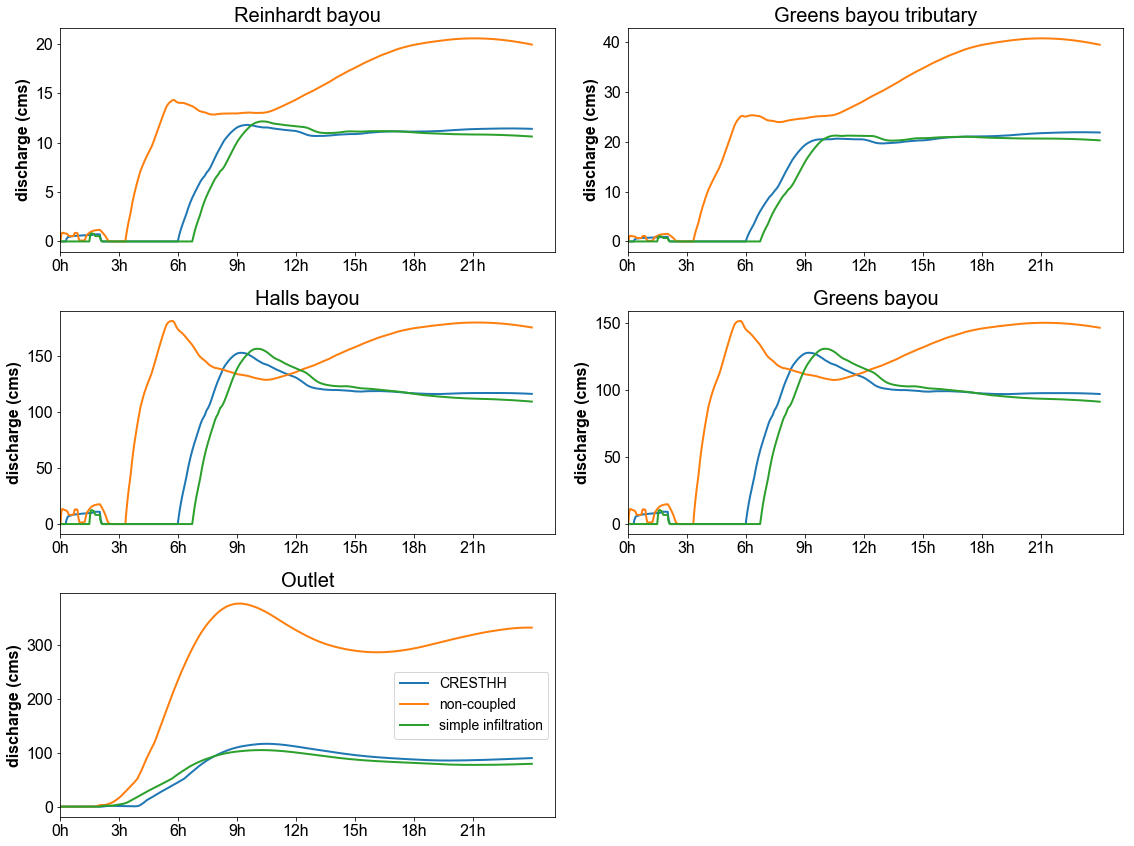

In [100]:
labels= ['tributary 1', 'tributary 2', 'tributary 3', 'tributary 4']
iloc_1= locale(pnt_1[0],pnt_1[1], coupledSplotter)
fig= plt.figure(figsize=(16,12))
ax= fig.add_subplot(321)
ax.plot(discharge_coupled[0], label='CRESTHH')
ax.plot(discharge_noncoupled[0], label='non-coupled')
ax.plot(discharge_infiltration[0], label='simple infiltration')
ax.set_title('Reinhardt bayou')
# ax.plot(benchmark.Q.values, label='outlet')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])

ax= fig.add_subplot(322)
ax.plot(discharge_coupled[1], label='CRESTHH')
ax.plot(discharge_noncoupled[1], label='non-coupled')
ax.plot(discharge_infiltration[1], label='simple infiltration')
ax.set_title('Greens bayou tributary')
# ax.plot(benchmark.Q.values, label='outlet')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])

ax= fig.add_subplot(323)
ax.plot(discharge_coupled[2], label='CRESTHH')
ax.plot(discharge_noncoupled[2], label='non-coupled')
ax.plot(discharge_infiltration[2], label='simple infiltration')
ax.set_title('Halls bayou')
# ax.plot(benchmark.Q.values, label='outlet')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])

ax= fig.add_subplot(324)
ax.plot(discharge_coupled[3], label='CRESTHH')
ax.plot(discharge_noncoupled[3], label='non-coupled')
ax.plot(discharge_infiltration[3], label='simple infiltration')
ax.set_title('Greens bayou')
# ax.plot(benchmark.Q.values, label='outlet')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])

ax= fig.add_subplot(325)
ax.plot(benchmark.Q.values, label='CRESTHH')
ax.plot(noncoupled_10m.Q.values, label='non-coupled')
ax.plot(infil.Q.values, label='simple infiltration')
ax.set_title('Outlet')
# ax.plot(benchmark.Q.values, label='outlet')
ax.set_ylabel('discharge (cms)')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])

plt.legend();

# discharge grids

In [55]:
crosssections= gpd.read_file('/home/ZhiLi/CRESTHH/data/crosssection/batch.shp')

In [52]:
def sample_points_from_line(line, samples):
    llcorner= np.array(line.geometry.coords)[0]
    urcorner= np.array(line.geometry.coords)[1]
    x= np.linspace(llcorner[0], urcorner[0],samples)
    y= np.linspace(llcorner[1], urcorner[1],samples)
    values= line.iloc[3:-1].values
    
    return x, y, values

In [53]:
def make_Q_grids(splotter,crosssections, samples, loc='vertice'):
    
    if not isinstance(splotter, SWW_plotter):
        msg= 'expected SWW_plotter object at arg[0]'
        raise msg
    if not isinstance(crosssections, gpd.geodataframe.GeoDataFrame):
        msg= 'expected geopands data at arg[1]'
        raise msg
    if loc not in ['vertice', 'centroid']:
        msg= "expected arg[2] to be either 'vertice' or 'centroid' "
        raise msg
    if loc=='centroid':
        xc= splotter.xc + splotter.xllcorner
        yc= splotter.yc + splotter.yllcorner
        Q_grid= np.zeros(splotter.depth.shape)
    elif loc=='vertice':
        xc= splotter.x + splotter.xllcorner
        yc= splotter.y + splotter.yllcorner
        Q_grid= np.zeros((splotter.depth.shape[0], len(splotter.x)))
    for i in range(len(crosssections)):

        section= crosssections.iloc[i]
        x,y,elev= sample_points_from_line(section,samples)

        spacing= ((x[1]-x[0])**2 + (y[1]-y[0])**2)**.5
        iloc= np.argmin((xc-x.mean())**2 + (yc-y.mean())**2)
        for it in range(splotter.depth.shape[0]):
            _stage= splotter.stage[it,iloc]
            _speed= splotter.speed[it,iloc]
            _mask= np.where(elev<_stage)[0]
            _area= ((_stage-elev[_mask]) * spacing).sum()
            Q_grid[it,iloc]=_area*_speed
    return Q_grid
    

In [102]:
# Q_grid_c= make_Q_grids(coupledSplotter, crosssections,40,loc='centroid')
Q_grid= make_Q_grids(coupledSplotter, crosssections,40,loc='vertice')

In [57]:
np.where(Q_grid_c==Q_grid_c)

(array([221]), array([52554]))

In [25]:
from netCDF4 import Dataset

In [22]:
xi, yi, Q= interpolateSplotter(coupledSplotter,Q_grid[104], np.arange(0,38000,10), np.arange(0,25000,10))

NameError: name 'Q_grid' is not defined

In [26]:
def arr2raster(dst, arr, lons, lats, xllcorner, yllcorner):
    cols= arr.shape[1]
    rows= arr.shape[0]
    originX= lons[0,1]
    originY= lats[1,0]
    lon_diff= lons[0,1] - lons[0,0]
    lat_diff= lats[1,0]- lats[0,0]
    originX+= float(xllcorner)
    originY+= float(yllcorner)
    driver= gdal.GetDriverByName('GTiff')
    outdata= driver.Create(dst, cols, rows, 1, gdal.GDT_Float32)
    print originX, lon_diff, 0, originY, 0, lat_diff
    outdata.SetGeoTransform((originX, lon_diff, 0, originY, 0, lat_diff))
    outdata.SetProjection('EPSG:32215')

    outdata.GetRasterBand(1).WriteArray(arr)
#     print(arr.shape, cols, rows, originX, lon_diff,originY,lat_diff)

In [119]:
arr2raster('discharge.tif', Q, xi, yi, coupledSplotter.xllcorner, coupledSplotter.yllcorner)

250767.348811594 10 0 3301340.01937773 0 10


In [117]:
gdal.Open('discharge.tif').GetGeoTransform()

(250767.348811594, 10.0, 0.0, 3301340.01937773, 0.0, 10.0)

In [22]:
discharges= []
for i, point in enumerate([pnt_1, pnt_2, pnt_3, pnt_4]):
    xc= coupledSplotter.xc + coupledSplotter.xllcorner
    yc= coupledSplotter.yc + coupledSplotter.yllcorner
    iloc= np.argmin((xc-pnt_1[0])**2 + (yc-pnt_1[1])**2)
    discharges.append(Q_grid[:,iloc])

In [31]:
nc= Dataset('Coupled_10m_modified_mesh.sww')

In [35]:
nc.createVariable('Q_c', 'f8', ('number_of_timesteps', 'number_of_volumes'))
nc.createVariable('Q', 'f8', ('number_of_timesteps', 'number_of_points'))

<type 'netCDF4._netCDF4.Variable'>
float64 Q_c(number_of_timesteps, number_of_volumes)
unlimited dimensions: number_of_timesteps
current shape = (721, 79137)
filling on, default _FillValue of 9.96920996839e+36 used

<type 'netCDF4._netCDF4.Variable'>
float64 Q(number_of_timesteps, number_of_points)
unlimited dimensions: number_of_timesteps
current shape = (721, 45194)
filling on, default _FillValue of 9.96920996839e+36 used

In [40]:
nc['Q_c'][:]= Q_grid_c
nc['Q'][:]= Q_grid

In [44]:
nc.close()

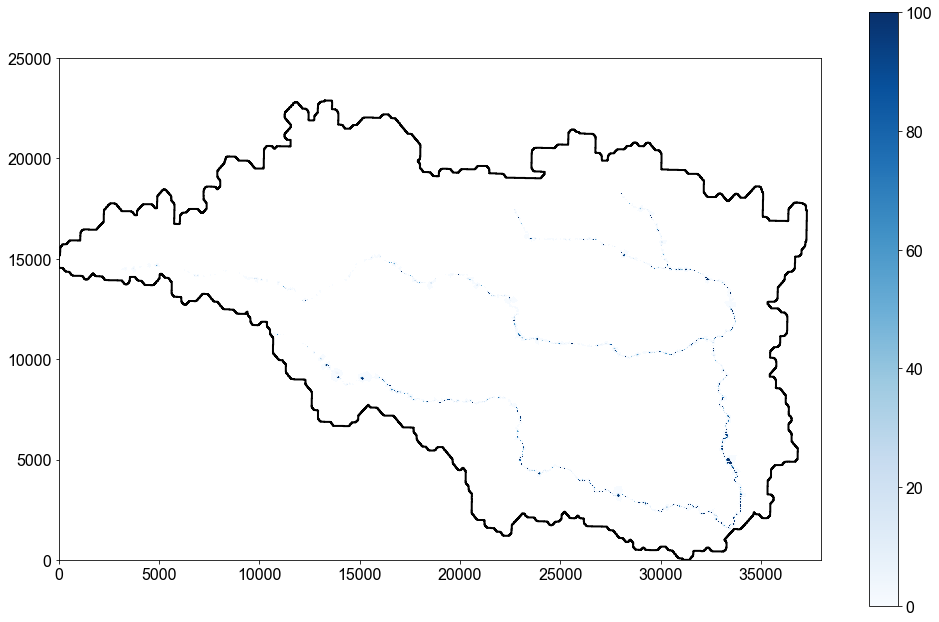

In [232]:
Q[Q==0]= np.nan
plt.imshow(Q,origin='lower left', cmap='Blues', extent=[xi.min(), xi.max(),yi.min(),yi.max()],vmin=0, vmax=100)
plt.colorbar()
plt.plot(x, y, 'k');

# Level 2: Mesh

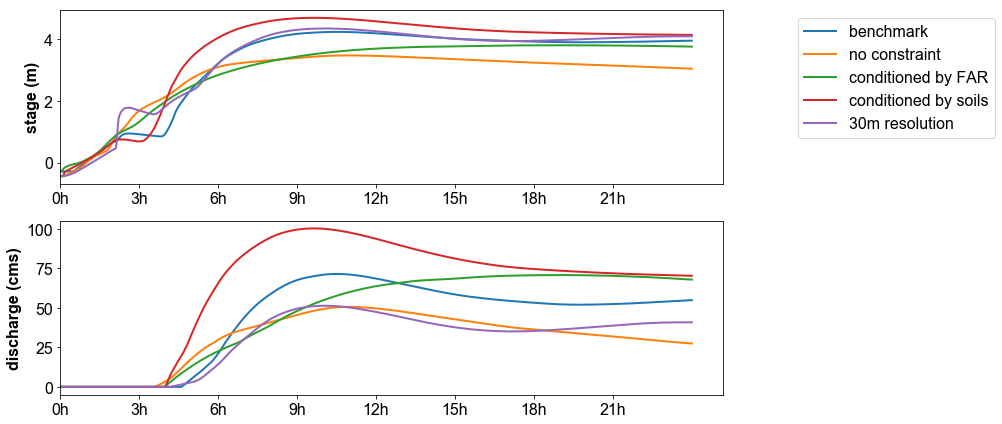

In [197]:
fig= plt.figure(figsize=(14,6))
ax= fig.add_subplot(211)
ax.plot(benchmark.stage.values, label='benchmark')
ax.plot(coupled_noConstraint.stage.values, label='no constraint')
ax.plot(coupled_FAM.stage.values, label='conditioned by FAR')
ax.plot(soil.stage.values, label='conditioned by soils')
ax.plot(coupled_30m.stage.values, label='30m resolution')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('stage (m)')
plt.legend(fontsize=16, bbox_to_anchor=(1.1,1));
ax= fig.add_subplot(212)
ax.plot(benchmark.Q.values, label='benchmark')
ax.plot(coupled_noConstraint.Q.values, label='no constraint')
ax.plot(coupled_FAM.Q.values, label='conditioned by FAR')
ax.plot(soil.Q.values, label='conditioned by soils')
ax.plot(coupled_30m.Q.values, label='30m resolution')
ax.set_xticks(np.arange(0,24*30,3*30))
ax.set_xticklabels(['%dh'%i for i in np.arange(0,24,3)])
ax.set_xlim([0,None])
ax.set_ylabel('discharge (cms)');
# plt.xticks(np.arange(0,24,3), ['%dh'%i for i in np.arange(0,24
,3)]);


In [344]:
xi,yi,MD_benchmark= interpolate('Coupled_10m_modified_mesh.sww', np.arange(0,38000,10), np.arange(0,25000,10))
xi,yi,MD_estimator= interpolate('Coupled_10m_modified_mesh_Ksat.sww', np.arange(0,38000,10), np.arange(0,25000,10))

In [345]:
MD_benchmark=MD_benchmark.filled(np.nan)
MD_estimator=MD_estimator.filled(np.nan)

In [346]:
# MD_benchmark= MD_benchmark.filled(np.nan)
# MD_estimator= MD_benchmark.filled(np.nan)
new_field= np.zeros(MD_benchmark.shape)
rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator>0.2) & (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=3
rows,cols= np.where((MD_benchmark>0.2) & (MD_estimator<=0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=2
rows,cols= np.where((MD_benchmark<=0.2) & (MD_estimator>0.2)& (~np.isnan(MD_estimator)) & (~np.isnan(MD_benchmark)))
new_field[rows, cols]=1

new_field[np.isnan(MD_benchmark)]=np.nan

# new_field[mask_misses]=2
# new_field[mask_false]=1

hits_p= float((new_field==3).sum())/((~np.isnan(new_field)).sum())*100.
misses_p= float((new_field==2).sum())/((~np.isnan(new_field)).sum())*100.
false_p= float((new_field==1).sum())/((~np.isnan(new_field)).sum())*100.
neg_p = float((new_field==0).sum())/((~np.isnan(new_field)).sum())*100.

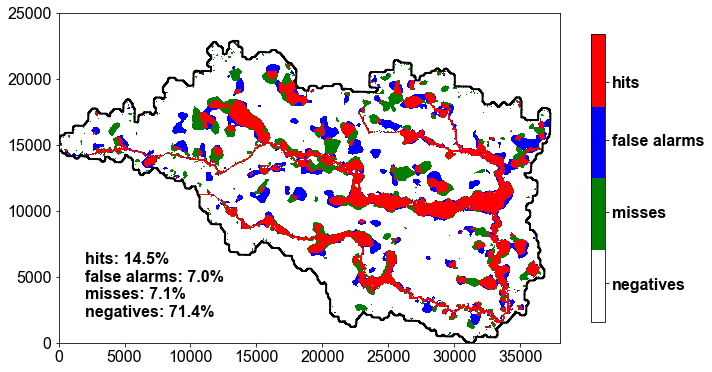

In [347]:
cmap = ListedColormap(['white', 'b', 'g', 'r'])
fig=plt.figure(figsize=(10,6))
# estimator.triang.set_mask(estimator.depth.max(axis=0) <=0.2)
plt.imshow(new_field, origin='lower left', cmap=cmap, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
cbar= plt.colorbar(ticks=[0.4,1.15,1.9,2.5], shrink=0.7)
# cbar.ax.set_yticks([1.25,2.00,2.75])
cbar.ax.set_yticklabels(['negatives','false alarms','misses','hits'], weight='bold')
plt.text(2000,2000,'hits: %.1f%s\nmisses: %.1f%s\nfalse alarms: %.1f%s\nnegatives: %.1f%s'%(hits_p,'%', misses_p,'%', false_p,'%', 100-hits_p-misses_p-false_p,'%'), fontsize=16, weight='bold')
plt.plot(x, y, 'k');

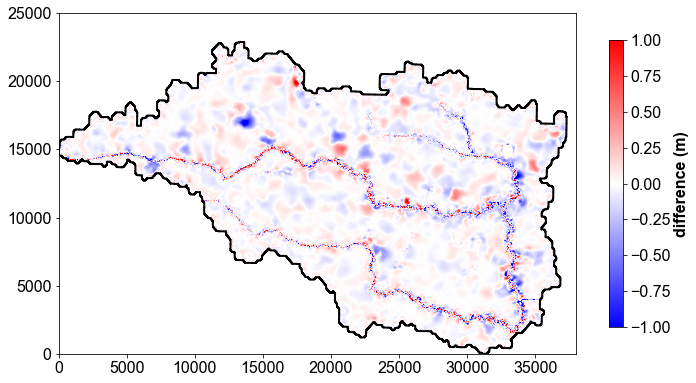

In [348]:
difference= MD_estimator- MD_benchmark
fig=plt.figure(figsize=(10,6))
plt.imshow(difference, origin='lower left', cmap='bwr', vmin=-1, vmax=1, extent=[xi.min(), xi.max(),yi.min(),yi.max()])
cbar= plt.colorbar(shrink=0.7)
cbar.ax.set_ylabel('difference (m)')
plt.plot(x, y, 'k');

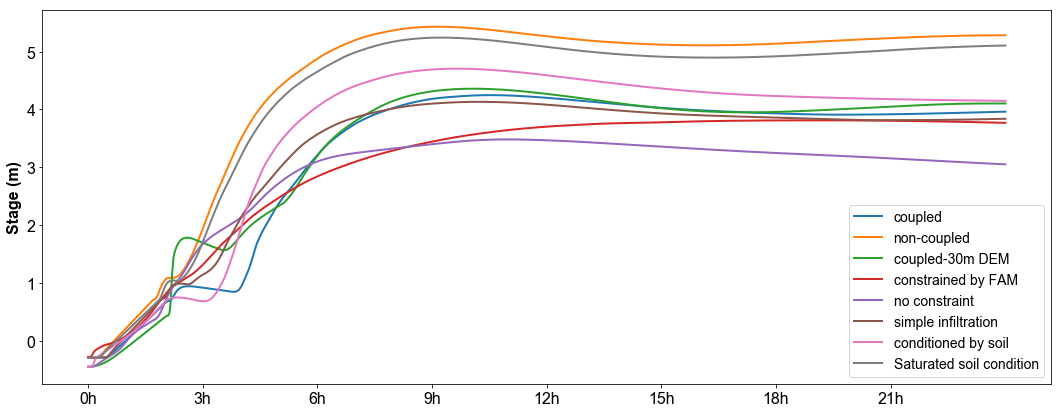

In [7]:
plt.figure(figsize=(15,6))
plt.plot(benchmark.stage.values, label='coupled')
plt.plot(noncoupled_10m.stage.values, label='non-coupled')
plt.plot(coupled_30m.stage.values, label='coupled-30m DEM')
plt.plot(coupled_FAM.stage.values,label='constrained by FAM')
plt.plot(coupled_noConstraint.stage.values,label='no constraint')
plt.plot(infil.stage.values, label='simple infiltration')
plt.plot(soil.stage.values, label='conditioned by soil')
plt.plot(saturated.stage.values, label='Saturated soil condition')
plt.xticks(np.arange(0,24*30,3*30),['%dh'%i for i in np.arange(0,24,3)] )
plt.ylabel('Stage (m)')
plt.legend();

In [8]:
crest= pd.read_csv('../calibration/ts.08076700.crest.csv')

In [40]:
plt.figure(figsize=(15,6))
plt.plot(benchmark.Q.values, label='coupled')
plt.plot(noncoupled_10m.Q.values, label='non-coupled')
plt.plot(coupled_30m.Q.values, label='coupled-30m DEM')
plt.plot(coupled_FAM.Q.values,label='constrained by FAM')
plt.plot(coupled_noConstraint.Q.values,label='no constraint')
plt.plot(infil.Q.values, label='simple infiltration')
plt.plot(soil.Q.values, label='conditioned by soil')
plt.plot(saturated.Q.values, label='Saturated soil condition')
plt.plot(np.append(0, crest.iloc[:,1].values*.1),label='CREST')
plt.xticks(np.arange(0,24*30,3*30),['%dh'%i for i in np.arange(0,24,3)] )
plt.ylabel('discharge (cms)')
plt.legend();

NameError: name 'benchmark' is not defined

<Figure size 1080x432 with 0 Axes>

In [5]:
benchmark= processSWW('temp.sww', ['depth','speed','stage'], OUTLET, start_time=pd.to_datetime('20170825000000'))

Figure files for each frame will be stored in _plot


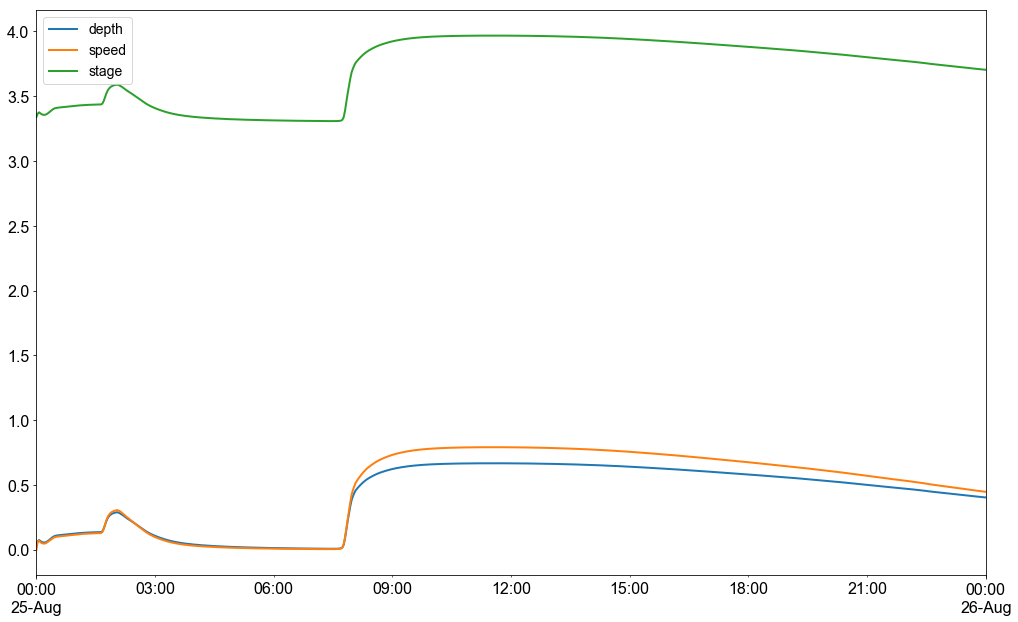

In [7]:
benchmark.plot()